# Evaluate MPNN Performance
Review the models which have been trained and pick one for our application.

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Load in the Models
They are all located in a directory with a `test_summary.json` file

In [13]:
model_dirs = list(map(os.path.dirname, glob(os.path.join('networks', '**', 'test_summary.json'))))
print(f'Found {len(model_dirs)} model directories')

Found 4 model directories


In [14]:
def get_summary(path):
    """Get the summary of a run"""
    
    output = {'path': path}
    
    # Load the config
    with open(os.path.join(path, 'config.json')) as fp:
        output.update(json.load(fp))
        
    # Load in the run summary
    with open(os.path.join(path, 'test_summary.json')) as fp:
        output.update(json.load(fp))
    return output

In [15]:
models = pd.DataFrame(get_summary(p) for p in model_dirs).sort_values('mae')
models.head(5)

,path,atom_features,num_messages,output_layers,batch_size,num_epochs,readout_fn,atomwise,device,r2_score,spearmanr,kendall_tau,mae,rmse,test_time
2,networks/T6_b32_n512_58d734,128,6,3,32,512,softmax,True,cuda,0.543984,0.824457,0.648272,0.428973,0.718695,0.465952
0,networks/T6_b32_n512_1f977d,128,6,3,32,512,avg,False,cuda,0.500842,0.802114,0.637507,0.458665,0.761208,0.437992
1,networks/T6_b32_n512_6e5bef,128,6,3,32,512,sum,True,cuda,0.531061,0.806873,0.632105,0.470531,0.754309,0.411848
3,networks/T6_b32_n512_5c1159,128,6,3,32,512,sum,False,cuda,0.492441,0.793294,0.609590,0.477765,0.761874,0.396391


## Validate the Model
Visualize the results on the hold-out set of 10% of our data

In [16]:
best_model = models.iloc[0]

In [17]:
best_model

path             networks/T6_b32_n512_58d734
atom_features                            128
num_messages                               6
output_layers                              3
batch_size                                32
num_epochs                               512
readout_fn                           softmax
atomwise                                True
device                                  cuda
r2_score                            0.543984
spearmanr                           0.824457
kendall_tau                         0.648272
mae                                 0.428973
rmse                                0.718695
test_time                           0.465952
Name: 2, dtype: object

In [18]:
test_data = pd.read_csv(os.path.join(best_model['path'], 'test_results.csv'))

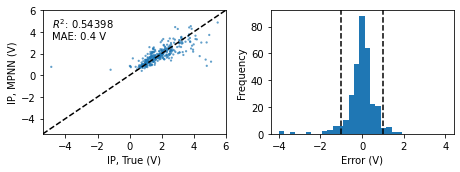

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

errors = (test_data['pred'] - test_data['true'])

ax = axs[0]
ax.scatter(test_data['true'], test_data['pred'], s=5, alpha=0.7, edgecolor='none')
ax.text(0.05, 0.95, f'$R^2$:{best_model["r2_score"]: .5f}\nMAE:{errors.abs().mean(): .1f} V', 
       transform=ax.transAxes, va='top', ha='left')

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('IP, True (V)')
ax.set_ylabel('IP, MPNN (V)')

ax = axs[1]


ax.hist(errors, bins=np.linspace(-4, 4, 32))
ax.text(1, 0.95, f'', 
       transform=ax.transAxes, va='top', ha='right')

ax.set_ylim(ax.get_ylim())
ax.plot([-1, -1], ax.get_ylim(), 'k--')
ax.plot([1, 1], ax.get_ylim(), 'k--')

ax.set_xlabel('Error (V)')
ax.set_ylabel('Frequency')
fig.tight_layout()

Link the best model to the local directory

In [20]:
if os.path.exists('best_model'):
    os.unlink('best_model')
os.symlink(os.path.join(best_model['path'], 'best_model'), 'best_model')

In [21]:
if os.path.exists('best_config.json'):
    os.unlink('best_config.json')
os.symlink(os.path.join(best_model['path'], 'config.json'), 'best_config.json')

In [22]:
if os.path.exists('best_performance.json'):
    os.unlink('best_performance.json')
os.symlink(os.path.join(best_model['path'], 'test_summary.json'), 'best_performance.json')